# News words tagging

This notebook shows an example of how to work with NLP techniques to extract the most common words in a specific news article. <br>
Also, more advanced topics like topic modelling will be covered.

This notebook presents an end-to-end project and cover several Data Science techniques, such as: 
- **Scrapping:** to extract data from the provided news article, we need to scrap it. After that, we are going to pass this extracted text into 
    the NLP engine, which is going to be the responsible to derive meaning and insights from the raw data;
- **Natural Language Processing (NLP):** The NLP engine will be the responsible to clean the text, apply different techniques to extract 
    the keywords of a news article. Next, will feed the extracted keywords to the webservice to be displayed in a very simple and intuitive web application;
- **Webservice:** Finnaly, the webservice component will be the responsible to provide raw data extracted from the news article to the NLP engine; 
    next, the keywords derived from the text are passed back to the web application which made the call in a matter of seconds.

### Importing libraries

In [1]:
%matplotlib notebook
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import pandas as pd
import numpy as np
import gensim 
from gensim import corpora, models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from wordcloud import WordCloud
import string
import collections
from sklearn.cluster import KMeans
from pprint import pprint
from bs4 import BeautifulSoup as soup
from urllib.request import urlopen as req
import requests, json

C:\Users\Luiz Henrique\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# Collecting punctuation symbols to be removed from the terms
ponctuation = set(string.punctuation)
# Collecting the set of English stopwords
stopwords = set(stopwords.words('english'))

In [3]:
# Create a list of some other common words in news articles
vocabulary = ["said", "'s", "''", "``", "also", "told", "says", "say", "tell",
             "sunday", "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", 
             "according", "reported"]

In [4]:
def text_normalization(document):
    
    '''
        Description: This function receives the original text extracted from the news article and apply NLP transformations to normalize it.
        
        Args: 
            - document (string): the original text scrapped from news website
        
        Returns: 
            - normalized_text (string): the normalized text after applying NLP transformations
    
    '''
    
    WNlemma = nltk.WordNetLemmatizer()
   
    # Improving results excluding tags which are not so important
    exclude_tags = ['IN', 'CD', 'MD', 'LS', 'POS', 'PRP$']
    
    # Normalize text by applying NLP transformations to each token of the text
    cleaned_document = ' '.join([s.lower() for s in document.split() 
                                # Removes stopwords (words that don't have much meaning in the analysis) such as 'the', 'as', 'that', etc
                                if s not in stopwords 
                                # It keeps only words with a lenth greater than 2
                                if len(s) >= 2
                                # It removes words in the vocabulary. The vocabulary is a list of common words in news articles that do not have much meaning in the
                                # overall result
                                if s not in vocabulary 
                                # Removes numbers and other special characters
                                if s.isalpha()])
    
    # Sentence tokenize the text
    normalized_text = nltk.sent_tokenize(cleaned_document)
    
    # Word tokenize the input text
    normalized_text = [nltk.word_tokenize(s) for s in normalized_text]
    
    # Extract the pos_tag from the text
    pos_tag = [nltk.pos_tag(s) for s in normalized_text]
    
    # Apply the transformations to each extracted token and join them after the transformations to get the original text back, but without
    # specified caracters (cleaned)
    normalized_text = ' '.join([item[0] for item in [item for item in pos_tag][0] 
                                # It removes pos_tags elements that are not so important for the overall meaning
                                if item[1] not in exclude_tags
                                # It removes ponctuation from text, as they are frequent in every article, but don't have any specific meaning
                                if item[0] not in ponctuation])
    # Additionally, lemmatize the tokens to improve results 
    normalized_text = " ".join(WNlemma.lemmatize(word) for word in normalized_text.split())
    
    # Returns the normalized text
    return normalized_text

In [5]:
def text_tokenize(text):
    
    '''
        Decription: This function receives a raw input text and returns it tokenized.
        
        Args: 
            - text (string): the raw text to tokenize
        
        Returns: 
            - tokenized_text (string): tokenized text 
        
    '''
    
    tokenized_text = nltk.word_tokenize(text)
    
    return tokenized_text

#### Website scrapping

In [6]:
def process_url(urls):
    
    '''
        Description: This function scrappes Fox News website to retrive the text from news articles 
        
        Args: 
        
            - urls (list): list of news articles's urls to scrap
        
        Returns: extracted_content_df (dataframe): extracted content from news article
            - 
    '''
    
    # List to append text scrapped from news article
    extracted_content = []
    
    # Iterate over the articles' urls
    for item in range(len(urls)):
        # Print current url being processed
        print("loaded url {} of {} ".format((item+1), len(urls)))
        
        # Making a call to the request library passing the url as parameter
        client = req(urls[item])
        
        # Reading the raw html returned by the request call 
        raw_html = client.read()
        
        # Parsing the result
        page_soup = soup(raw_html, "html.parser")
        
        # Looking for the div 'article-body', which is the main part of the article
        article_body = page_soup.findAll("div", {"class": "article-body"})
        
        # Saving the article body in another variable
        article = article_body
        
        # Getting the value from the article body
        content = article_body[0]
        
        # Looking for the paragraph tags with the class 'speakable'
        speakeable = content.findAll("p", {"class": "speakable"})
        
        # Iterate over each 'speakable' item
        speakeable = [item.text for item in speakeable]
        
        # Join the whole text into a single object
        speakeable_text = ' '.join(speakeable)
        
        # Fining other paragraph tags inside the article
        paragraphs = content.findAll("p")
        
        # Iterate over the paragraphs
        body_text=[item.text for item in paragraphs]
        
        # Joining 'speakable' text
        joined_text = ' '.join(speakeable_text)
        
        # Joining body content
        joined_text = ' '.join(body_text)
        
        # Passing data into the normalization function
        cleaned_text = text_normalization(joined_text.strip())
        
        # Saving result into the `extracted_content` list
        extracted_content.append({"text" : cleaned_text})
    
    # Printing a message to alert the user about the completion of the process 
    print("process completed!")
    
    # Saving the final output into a dataframe
    extracted_content_df = pd.DataFrame(extracted_content)
    
    # Returning the final output as a dataframe
    return extracted_content_df

    # Closing the request connection
    client.close()

In [7]:
# Sample URLs to extract the content
links = [
    "http://www.foxnews.com/world/2017/11/24/search-for-missing-argentine-submarine-will-continue-countrys-president-says.html",
    "http://www.foxnews.com/world/2017/11/25/navy-ids-three-sailors-lost-in-plane-crash-in-philippine-sea.html",
    "http://www.foxnews.com/world/2017/11/25/argentinas-navy-insists-missing-sub-was-in-good-condition-before-mission.html",
    "http://www.foxnews.com/us/2017/11/26/2-arrested-in-robbery-92-year-old-massachusetts-woman.html",
    "http://www.foxnews.com/us/2017/11/26/nyc-teacher-accused-being-sugar-daddy-to-teen-girl-student-giving-her-cash-for-sex.html",
    "http://www.foxnews.com/sports/2017/11/26/ohio-state-quarterbacks-knee-injury-before-michigan-game-prompts-calls-for-investigation.html",
    "http://www.foxnews.com/us/2017/11/26/football-players-charged-as-adults-in-alleged-rape-14-year-old-girl.html",
    "http://www.foxnews.com/entertainment/2017/11/26/glee-star-naya-rivera-charged-with-domestic-battery-in-west-virginia.html",
    "http://www.foxnews.com/tech/2017/11/22/cyber-mondays-biggest-deals-and-savings.html",
    "http://www.foxnews.com/world/2017/11/26/will-conservatives-social-democrats-form-grand-coalition-and-give-merkel-lifeline.html",
    "http://www.foxnews.com/us/2017/11/26/missing-florida-boy-may-have-witnessed-murder-week-before-disappearance.html",
    "http://www.foxnews.com/entertainment/2017/11/26/house-cards-extends-production-hiatus-amid-kevin-spacey-probe.html",
    "http://www.foxnews.com/entertainment/2017/11/26/coco-dominates-thanksgiving-box-office-as-justice-league-falls.html",
    "http://www.foxnews.com/us/2017/11/25/flat-earth-rocket-launch-postponed-california-man-says.html",
    "http://www.foxnews.com/tech/2017/11/24/hackers-putting-porn-on-isis-propaganda-sites-report-says.html",
    "http://www.foxnews.com/tech/2017/11/24/facebook-tool-will-show-russian-propaganda-fell-for.html",
    "http://www.foxnews.com/food-drink/2017/11/26/fast-food-employee-tricks-twitter-with-soda-cup-illusion.html",
    "http://www.foxnews.com/us/2017/11/25/california-police-investigate-surveillance-video-after-looters-steal-1800-gallons-vodka.html",
    "http://www.foxnews.com/health/2017/11/24/why-many-pregnant-women-arent-screened-for-deadly-skin-cancers.html",
    "http://www.foxnews.com/health/2017/11/25/couple-gets-wedding-reception-do-over-after-brides-health-scare.html",
    "http://www.foxnews.com/world/2017/11/26/argentine-navy-not-giving-hope-submarine-survivors.html",
    "http://www.foxnews.com/world/2017/11/26/south-korea-taunts-north-korea-over-defecting-soldier-by-broadcasting-news-through-loudspeakers-report-says.html",
    "http://www.foxnews.com/world/2017/11/26/thousands-protest-romanias-tax-justice-laws.html",
    "http://www.foxnews.com/world/2017/11/26/egyptian-village-where-mosque-was-attacked-had-been-warned.html"
]

# Making a call to the `process_url` function passing the list of URLs as parameter
df_news = process_url(links)

# Showing top results
df_news.head()

loaded url 1 of 24 
loaded url 2 of 24 
loaded url 3 of 24 
loaded url 4 of 24 
loaded url 5 of 24 
loaded url 6 of 24 
loaded url 7 of 24 
loaded url 8 of 24 
loaded url 9 of 24 
loaded url 10 of 24 
loaded url 11 of 24 
loaded url 12 of 24 
loaded url 13 of 24 
loaded url 14 of 24 
loaded url 15 of 24 
loaded url 16 of 24 
loaded url 17 of 24 
loaded url 18 of 24 
loaded url 19 of 24 
loaded url 20 of 24 
loaded url 21 of 24 
loaded url 22 of 24 
loaded url 23 of 24 
loaded url 24 of 24 
process completed!


,text
0,search continues crew member the search missin...
1,plane crashed coast the navy identified sailor...
2,navy insisted ara san juan submarine good cond...
3,kayla markell arrested authority robbing polic...
4,nyc high school spanish teacher martin howfiel...


In [8]:
def frequent_terms(normalized_text):
    
    '''
        Description: This function extracts the most frequent terms from a provided text.
        
        Args: 
            - normalized_text (string): a text string in a normalized state
            
        Returns: 
            - (terms, frequency) (tuple(list)): a tuple of lists with the most frequent terms and their respective frequencies
    
    '''
        
    # Creates an object with the frequency of each word in the text
    freq_dist=FreqDist(text_tokenize(normalized_text))
   
    # Unpacks the terms and the respective frequency
    (terms, frequency)=zip(*[(item[0], item[1]) 
                             
                         # Iterate over the most common terms
                         for item in freq_dist.most_common() 
                             
                         # Check if it's alphanumeric
                         if item[0].isalpha() 
                             
                         # Check if it's not punctuation
                         if item[0] not in ponctuation 
                         
                         # Check if it's not stopword
                         if item[0] not in stopwords 
                         
                         # Check if it's not in the vocabulary (from words to remove)
                         if item[0] not in vocabulary 
                         
                         # Check if the length is greater than 2
                         if len(item[0]) > 2
                         if item[1] >= 2][:10])
    
    # Returns the most common terms with their respective frequencies
    return (terms, frequency)

In [9]:
# Generating a random index to pick a URL randomly
rand_index = np.random.randint(0, 23)

In [10]:
# Getting the text from the chosen index
normalized_text = df_news['text'].values[rand_index]

In [11]:
# Extracting terms and frequency from the normalized text
(terms, frequency) = frequent_terms(normalized_text)

In [12]:
# Printing the terms
terms

('melanoma',
 'woman',
 'pregnant',
 'medicaid',
 'skin',
 'pregnancy',
 'cancer',
 'health',
 'study',
 'new')

In [13]:
# Printing the frequencies
frequency

(23, 14, 11, 10, 7, 6, 6, 5, 5, 5)

### Visualizing the terms distribution for this article 

#### Using barplot to visualize the most common words in this text

<IPython.core.display.Javascript object>


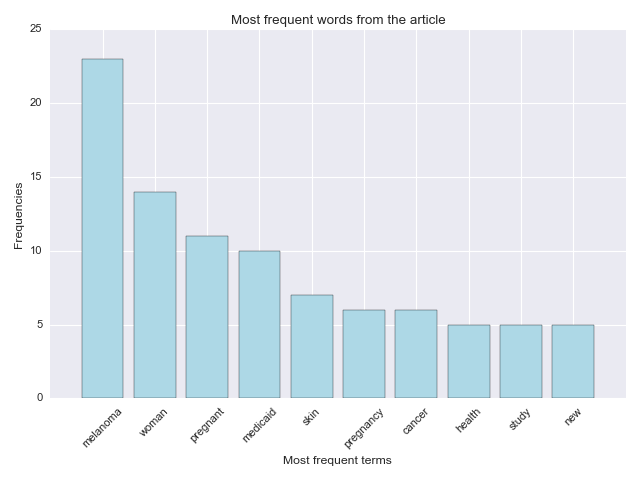

In [14]:
# Plotting the most frequent terms with their respective weights
plt.figure(figsize=(8,6))
plt.bar([s for s in range(1, len(terms)+1)], frequency, color='lightblue', align='center');
ax = plt.gca()
ax.set_xticks(range(1, len(terms) + 1))
plt.xticks([s for s in range(1, (len(terms)+1))], terms, rotation=45);
plt.xlim(0,11)
plt.xlabel('Most frequent terms')
plt.ylabel('Frequencies')
plt.title('Most frequent words from the article')
plt.tight_layout()

#### Wordcloud of the most common terms in the article

In [15]:
# Finding stopwords
words=list(stopwords)

<IPython.core.display.Javascript object>


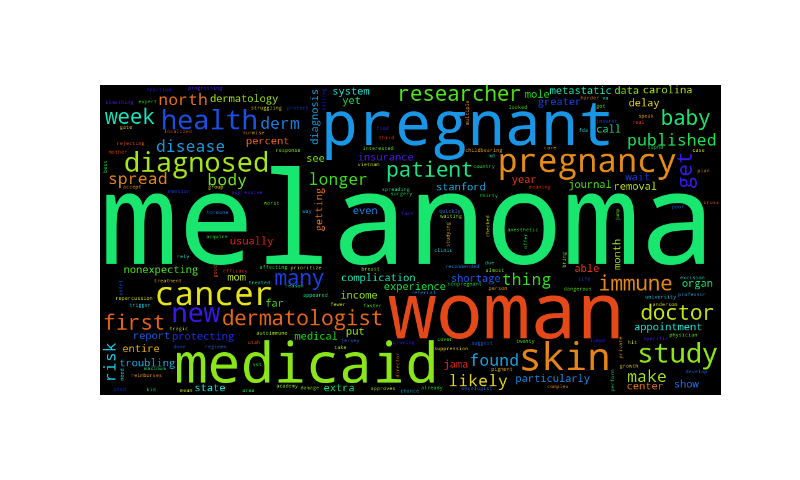

In [16]:
# Creating a word cloud chart with the most common terms, removing stopwords
plt.figure(figsize=(10,6))
wordcloud = WordCloud(width = 1000, height = 500, stopwords=words,
                     relative_scaling = 1.0).generate(normalized_text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Using CountVectorizer to extract most frequent words

In [17]:
def frequent_words_vectorizer(normalized_text):
    
    '''
        Description: This function extracts the most frequent terms from a normalized text using CountVectorizer method
        
        Args:
            - normalized_text (string): the normalized text to be analyzed
        
        Returns: 
            - most_common_feats (list): the list of most frequent terms
    
    '''
    
    vect = CountVectorizer(min_df=2, max_df=0.2, stop_words=words, 
                           token_pattern='(?u)\\b\\w\\w\\w+\\b',
                           ngram_range=(1,3))
    vect.fit_transform(normalized_text.split())
    
    most_common_feats = vect.get_feature_names()
    
    return most_common_feats

In [18]:
frequent_words_vectorizer(normalized_text)[:10]

['able',
 'appointment',
 'baby',
 'body',
 'call',
 'cancer',
 'carolina',
 'center',
 'complication',
 'data']

### Using Term-Frequency, Inverse Term-Frequency (TF-IDF) to extract most used words in the article

In [19]:
def get_frequent_words_tfidf(normalized_text):
     
    '''
        Description: This function extracts the most frequent terms from a normalized text using Term-Frequency, Inverse Term-Frequency (TF-IDF) method
        
        Args:
            - normalized_text (string): the normalized text to be analyzed
        
        Returns: 
            - most_common_feats (list): the list of most frequent terms
    
    '''
    
    tfidf_vect = TfidfVectorizer(
                                # Removes tokens that don't appear at least 2 times
                                min_df=2,
                        
                                # Removes tokens that appear in more than 20% of the documents
                                max_df=0.2,

                                # Use CountVectorizor to find three letter tokens, remove stop_words
                                stop_words=words,
                                
                                # Creating n-grams from tokens
                                ngram_range=(1,3))
    
    # Fit and transform
    tf_idf_fitted = tfidf_vect.fit_transform(text_tokenize(normalized_text))
    
    # Getting the most frequent terms
    most_common_feats = tfidf_vect.get_feature_names()
    
    # Returns the output
    return most_common_feats

In [20]:
# Getting the most common words using tf-idf technique
most_freq = get_frequent_words_tfidf(normalized_text)[:10]

### Most important features from TF-IDF

In [21]:
def get_scores(vectorizer, tf_idf):
    
    '''
        Description: This function returns the weight for each of the terms.
        
        Args: 
            - vectorizer (TfidfVectorizer): the matrix representation of the extracted terms
            - tf_idf (list): the list of most common words
            
        Returns: 
            - sorted_scores (list): the list of most common words with their respective weights
    
    '''
    
    # Getting the weights for the most frequent terms
    scores = zip(most_freq, np.asarray(tf_idf_fitted.sum(axis=0)).ravel())
    
    # Sorting the weights by ascending order
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Returning the output
    return sorted_scores

In [22]:
tfidf_vect = TfidfVectorizer(
                            # Removes tokens that don't appear at least 2 times
                            min_df=2,
   
                            # Removes tokens that appear in more than 20% of the documents                        
                            max_df=0.2,
    
                            # Use CountVectorizor to find three letter tokens, remove stop_words
                            stop_words=words,
    
                            # Creating n-grams from tokens
                            ngram_range=(1,3))

# Fit and transform
tf_idf_fitted = tfidf_vect.fit_transform(text_tokenize(normalized_text))

# Calling the `get_scores` function, passing the words matrix and the most frequent terms
tf_idf_scores = get_scores(tf_idf_fitted, most_freq)

# Printing the most frequent terms and their respective weights
tf_idf_scores

[('cancer', 6.0),
 ('baby', 4.0),
 ('body', 3.0),
 ('able', 2.0),
 ('appointment', 2.0),
 ('call', 2.0),
 ('carolina', 2.0),
 ('center', 2.0),
 ('complication', 2.0),
 ('data', 2.0)]

#### Printing the 10 most important terms on this article based on TF-IDF

In [23]:
# Creates a list to append results
dict_list = []

# Iterate over the result list, from the most frequent terms
for item in tf_idf_scores:
    
    # Appending each term and score to the list
    dict_list.append({"Term": item[0], "Score": item[1]})    

# Creating a dataframe object from it
df_features=pd.DataFrame(dict_list)

# Showin top 10 results
df_features.head(10)

,Score,Term
0,6.0,cancer
1,4.0,baby
2,3.0,body
3,2.0,able
4,2.0,appointment
5,2.0,call
6,2.0,carolina
7,2.0,center
8,2.0,complication
9,2.0,data


#### Have an idea on what's this news about?

### Comparing the results of FreqDist and TF-IDF

In [24]:
# Printing ters from FreqDist
print(terms)

# Printing terms from TF-IDF
[item[0] for item in tf_idf_scores if item[0] not in vocabulary][:10]

('melanoma', 'woman', 'pregnant', 'medicaid', 'skin', 'pregnancy', 'cancer', 'health', 'study', 'new')


['cancer',
 'baby',
 'body',
 'able',
 'appointment',
 'call',
 'carolina',
 'center',
 'complication',
 'data']

In [26]:
# Joining results from freqdist
joined_terms_freqdist = ', '.join([s for s in terms])

# Joining results from tfidf
joined_terms_tf_idf = ', '.join([item[0] for item in tf_idf_scores])

In [27]:
# Printing freqdist output
joined_terms_freqdist

'melanoma, woman, pregnant, medicaid, skin, pregnancy, cancer, health, study, new'

In [28]:
# Printing tfidf output
joined_terms_tf_idf

'cancer, baby, body, able, appointment, call, carolina, center, complication, data'

## Topic Modelling

In [29]:
count_vect = CountVectorizer(
                             # remove tokens that don't appear in at least 1% of the documents
                             min_df=0.01, 
                             # remove tokens that appear in more than 20% of the documents
                             max_df=0.2,
                             # Use CountVectorizor to find three letter tokens, remove stop_words
                             stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b', ngram_range=(1, 3))

# Fit and transform
X = count_vect.fit_transform(normalized_text.split())

# Convert sparse matrix to gensim corpus
corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map = dict((v, k) for k, v in count_vect.vocabulary_.items())

In [30]:
# Creating a LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=10, id2word=id_map, passes=25, random_state=34,
                                          iterations=200, minimum_probability=0.7)

In [31]:
# Print topics and terms per topic
ldamodel.print_topics(num_topics=5, num_words=10)

[(4,
  '0.910*"pregnancy" + 0.015*"pregnant" + 0.015*"cancer" + 0.015*"melanoma" + 0.015*"woman" + 0.015*"medicaid" + 0.015*"skin"'),
 (1,
  '0.975*"melanoma" + 0.004*"woman" + 0.004*"pregnant" + 0.004*"medicaid" + 0.004*"skin" + 0.004*"cancer" + 0.004*"pregnancy"'),
 (9,
  '0.949*"pregnant" + 0.009*"woman" + 0.009*"cancer" + 0.009*"melanoma" + 0.009*"medicaid" + 0.009*"skin" + 0.009*"pregnancy"'),
 (7,
  '0.959*"woman" + 0.007*"pregnant" + 0.007*"melanoma" + 0.007*"medicaid" + 0.007*"skin" + 0.007*"pregnancy" + 0.007*"cancer"'),
 (2,
  '0.144*"melanoma" + 0.143*"medicaid" + 0.143*"pregnant" + 0.143*"woman" + 0.143*"skin" + 0.143*"cancer" + 0.143*"pregnancy"')]

In [32]:
# Unpacks the topic terms and their respective weights
(topic_weights, topic_terms) = zip(*[(item[0], item[1]) 
                                     for item in list(sorted(ldamodel.top_topics(corpus, topn=10), key=lambda x: x[0], reverse=True)[0])[0]])

In [33]:
# Print the topic terms
print(topic_terms)

('melanoma', 'woman', 'pregnant', 'medicaid', 'skin', 'cancer', 'pregnancy')


In [34]:
# Print the topic importance weights
print(topic_weights)

(0.9746430120019669, 0.0042599295283686969, 0.0042194128703404487, 0.0042194121244026267, 0.0042194114144617073, 0.0042194111779354608, 0.0042194108825241621)


In [35]:
# Joining topic terms
joined_terms_topics = ', '.join([s for s in topic_terms])

In [36]:
# Printing the results
joined_terms_topics

'melanoma, woman, pregnant, medicaid, skin, cancer, pregnancy'

### Top terms among all the articles

In [37]:
def cluster_terms(text, clusters=3):
    
    '''
        Description: This function uses a KMeans clustering algorithm to cluster similar terms from all the news articles.
        
        Args:
            - text (string): the normalized text to be analyzed
            - clusters (int): receives the number of clusters to create; default is 3
            
        Results:
            - clusters (list): returns the list of clusters
    '''
    
    vectorizer = TfidfVectorizer(
                                # Removes tokens that don't appear at least 2 times
                                min_df=2,
        
                                # Removes tokens that appear in more than 20% of the documents
                                max_df=0.2,
        
                                # Use CountVectorizor to find three letter tokens, remove stop_words
                                stop_words=words)

    # Fit and transform
    tfidf_model = vectorizer.fit_transform(text)
    
    # Create KMeans model with desired n_clusters
    km_model = KMeans(n_clusters=clusters)
    
    # Fitting the model
    km_model.fit(tfidf_model)
    
    # Printing info message
    print("Top terms per cluster:")
    
    # Ordering terms inside cluster
    order_centroids = km_model.cluster_centers_.argsort()[:, ::-1]
 
    # Getting most common terms
    terms = vectorizer.get_feature_names()
    
    # Iterate over clusters
    for i in range(clusters):
        
        # Printing info message about current cluster
        print("Cluster %d:" % i, end='')
        
        # Iterating over each cluster
        for ind in order_centroids[i, :10]:
            
            # Printing elements on each group, separating items by comma
            print(' %s' % terms[ind], end=',')
            
        # Printing space between lines
        print()

    # Returning output clusters
    return (clusters)

#### creating n clusters with the most significant terms

In [38]:
# Printing result clusters
cluster_terms(normalized_text.split())

Top terms per cluster:
Cluster 0: study, yet, greater, experience, extra, far, first, found, get, getting,
Cluster 1: woman, pregnant, medicaid, skin, cancer, pregnancy, new, diagnosed, health, researcher,
Cluster 2: melanoma, yet, health, extra, far, first, found, get, getting, greater,


3

### Find syntatically similar words to the term provided using Fuzzywuzzy

In [39]:
# Importing libraries
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [40]:
# Finding similar words to 'good' in the text
process.extractBests("good", normalized_text.split())

[('good', 100),
 ('coordination', 68),
 ('looked', 60),
 ('got', 57),
 ('poor', 50)]

### Web service

### Creating a web service

#### This is the code for the RESTful API. For simplicity and to show the real utility of it, we are going to run the web service from another file, nlp_restful.py, but here is the code to create and run it:  

In [ ]:
app = Flask(__name__)

# Create RESTful webservice route with POST method
@app.route('/api', methods=['POST'])

def extract_keywords():
    
    '''
        Description: This function receives a website url passed as parameter, process it, and extracts the keywords which most represent the text, then return 
        them to the webservice.
        
        Args:
            - N/A
        
        Returns:
            - output (json object): returns a json object with the most frequent terms and their respective frequencies    
    '''
    
    # Get the request parameters
    data = request.get_json(force=True)
    
    # Extract only the desired parameter (in this case, there is only 1, but if more, you can select all or specify which one to pick)
    request_url = data['url']
    
    # Call the frequent_terms function passing the scrapped and cleaned news article
    most_frequent_terms = frequent_terms(process_url([request_url]))
    
    # Saving the output in a variable
    output = jsonify(results=most_frequent_terms)
    
    # Returns the extracted keywords and their respective weights, which are useful to draw and visualize the importance of each term
    return output


if __name__ == '__main__':
    
    # Run the API, waiting for requests on port 9000
    app.run(port=9000, debug=True)

### Making a request to web service

In [41]:
# Web service endpoint (URL)
ws_endpoint = "http://localhost:9000/api"

In [45]:
# Sample URL used in this example
"http://www.foxnews.com/health/2017/11/24/why-many-pregnant-women-arent-screened-for-deadly-skin-cancers.html"

'http://www.foxnews.com/health/2017/11/24/why-many-pregnant-women-arent-screened-for-deadly-skin-cancers.html'

In [42]:
# Data passed as parameter to the API the call. In this case, it's a simple news article's url
data = json.dumps({"url": links[rand_index]})

In [43]:
# Send the data to the API as a POST method
r = requests.post(ws_endpoint, data)

In [44]:
# Print the results
print (r.json())

{'results': [['melanoma', 'woman', 'pregnant', 'medicaid', 'skin', 'cancer', 'pregnancy', 'study', 'new', 'diagnosed'], [23, 14, 11, 10, 7, 6, 6, 5, 5, 5]]}
